In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tweet_preprocess_module as pre
from nltk.corpus import stopwords, twitter_samples

import csv
import numpy as np
import pandas as pd

from pandas import Series, DataFrame
import matplotlib.pyplot as plt

Hazır veriler:

In [2]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

Yardımcı fonksiyonlar:

In [3]:
def count_tweets(tweets: list, ys: list):
    """
    Calculates the words frequency and matches it with it's y value.
            
    Returns:
        freqs(dict): {(word, y): frequency}.
    """
    
    freqs = {}
    for y, tweet in zip(ys, tweets):
        clean_tweet = pre.process_tweet(tweet)
        for word in clean_tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs


def lookup(freqs: dict, word: str, label: int):
    """
    Looks up the given word's frequency.
    
    Returns:
        n(int): frequency.
    """
    n = 0
    pair = (word, label)
    if pair in freqs:
        n = freqs[pair]

    return n

In [4]:
freqs = count_tweets(train_x, train_y)

freqs[("happy", 1)]

150

Naive Bayes fonksiyonları:

In [5]:
def train_naive_bayes(freqs: dict, train_x: list, train_y: list):
    """
    Calculates the prior and the likelihood.
    """
    loglikelihood = {}
    logprior = 0

    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    N_pos = N_neg = 0
    for pair in freqs.keys():
        if pair[1] > 0:
            N_pos += freqs[pair]
        else:
            N_neg += freqs[pair]

    D = len(train_y)
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))
    logprior = np.log(D_pos) - np.log(D_neg)

    for word in vocab:
        freq_pos = lookup(freqs, word, 1)
        freq_neg = lookup(freqs, word, 0)

        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [6]:
logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)

loglikelihood

{'bbmme': 1.3899340375673404,
 'who': -0.6895075041124956,
 'rash': -0.6895075041124956,
 'pegell': 0.6967868570073951,
 'pierojogger': 0.6967868570073951,
 'anatomy': -0.6895075041124956,
 'doushite': -0.6895075041124956,
 'thur': 0.6967868570073951,
 'ahh': -0.3328325601737632,
 'migraine': -1.09497261222066,
 'katie': -0.40182543166071466,
 'chwang': -0.6895075041124956,
 'dus': -0.6895075041124956,
 'clear': 0.6967868570073951,
 'whoop': 1.61307758888155,
 'unluckiest': -0.6895075041124956,
 'tunnel': -1.09497261222066,
 'mz': 0.6967868570073951,
 'ovh': 1.1022519651155596,
 'pleasanton': -0.6895075041124956,
 'editor': -0.6895075041124956,
 'bottom': 0.0036396764474497336,
 "callie's": 0.6967868570073951,
 'everyone': 0.94190931504038,
 'event': 0.984468929459176,
 'smoke': 0.6967868570073951,
 'college': -0.6895075041124956,
 'snuggle': -0.6895075041124956,
 'leanneriner': 0.0036396764474497336,
 'berangkaat': 0.6967868570073951,
 'argos': 0.6967868570073951,
 'boy': 0.1706937611

In [7]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    """
    Predicts the given tweet's sentiment 
    with the trained Naive Bayes classifier.
    """
    word_l = pre.process_tweet(tweet)
    p = 0
    p += logprior

    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]

    return p

In [8]:
tweet = "All those moments will be lost in time, \
        like tears in rain. Time to die."
print(naive_bayes_predict(tweet, logprior, loglikelihood))

tweet = "I hate being bipolar, it's awesome"
print(naive_bayes_predict(tweet, logprior, loglikelihood))

tweet = "It’s a good thing I don’t like spinach, \
        because if I did, I’d eat it, \
        and I can’t stand the stuff."
print(naive_bayes_predict(tweet, logprior, loglikelihood))


-5.037156202790864
0.14081074551942208
-0.758299100914187


In [9]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    accuracy = 0

    y_hats = []
    for tweet in test_x:
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            y_hat_i = 1
        else:
            y_hat_i = 0
        y_hats.append(y_hat_i)

    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1 - error

    return accuracy

In [10]:
acc = test_naive_bayes(test_x, test_y, logprior, loglikelihood)
print(f"Accuracy: {acc:.2%}")

Accuracy: 99.15%


Naive Bayes algoritmasını kullanmadan, kelime frekansları ile pozitiflik/negatiflik oranı ölçen fonksiyonlar:

In [11]:
def get_ratio(freqs, word):
    pos_neg_ratio = {"positive": lookup(freqs, word, 1), 
                     "negative": lookup(freqs, word, 0), 
                     "ratio": 0.0}
    pos_neg_ratio["ratio"] = (pos_neg_ratio["positive"] + 1) / (pos_neg_ratio["negative"] + 1)

    return pos_neg_ratio


def get_words_by_threshold(freqs, label, threshold):
    word_list = {}

    for key in freqs.keys():
        word, _ = key
        pos_neg_ratio = get_ratio(freqs, word)

        if label == 1 and pos_neg_ratio["ratio"] >= threshold:
            word_list[word] = pos_neg_ratio
        elif label == 0 and pos_neg_ratio["ratio"] <= threshold:
            word_list[word] = pos_neg_ratio

    return word_list

In [12]:
get_words_by_threshold(freqs, 0, 1)

{'odd': {'positive': 1, 'negative': 1, 'ratio': 1.0},
 ':/': {'positive': 5, 'negative': 8, 'ratio': 0.6666666666666666},
 'please': {'positive': 78, 'negative': 242, 'ratio': 0.32510288065843623},
 'contact': {'positive': 4, 'negative': 7, 'ratio': 0.625},
 'centre': {'positive': 1, 'negative': 2, 'ratio': 0.6666666666666666},
 'able': {'positive': 6, 'negative': 17, 'ratio': 0.3888888888888889},
 'listen': {'positive': 13, 'negative': 14, 'ratio': 0.9333333333333333},
 'last': {'positive': 39, 'negative': 51, 'ratio': 0.7692307692307693},
 'get': {'positive': 223, 'negative': 271, 'ratio': 0.8235294117647058},
 'mark': {'positive': 1, 'negative': 2, 'ratio': 0.6666666666666666},
 'fb': {'positive': 3, 'negative': 4, 'ratio': 0.8},
 'long': {'positive': 28, 'negative': 35, 'ratio': 0.8055555555555556},
 'thought': {'positive': 4, 'negative': 4, 'ratio': 1.0},
 '’': {'positive': 17, 'negative': 19, 'ratio': 0.9},
 'enough': {'positive': 16, 'negative': 18, 'ratio': 0.8947368421052632},

Using mined data:

In [13]:
def sentiment_saver(file_name_wo_ex: str):
    df = pd.read_csv('tripadvisor_en.csv', sep='\t')
    df['label'] = -1
    
    for idx, line in enumerate(df.text.to_list()): 
        label = int(naive_bayes_predict(line, logprior, loglikelihood) >= 0)
        df['label'].iloc[idx] = label
        
    df.to_csv('tripadvisor_en_labeled.csv', sep='\t')
    
    return df

In [14]:
df_2021 = sentiment_saver("full_data")

/tmp/ipykernel_35635/3616511598.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'].iloc[idx] = label


In [15]:
df_2021.head()

,Unnamed: 0,title,text,travel_date,rating,location,label
0,0,Too small! Also this is not a city.,The cave was kind of interesting but tour guid...,2022-01,3,1,1
1,1,Fascinating but physically demanding,Derinkuyu is a fascinating underground city th...,2022-01,4,1,0
2,2,Visit before Kaymakli or skip it,Derinkuyu is the biggest underground town in t...,2021-08,3,1,1
3,3,Worth a visit.,Very enjoyable - but really intense... Narrow ...,2021-07,5,1,1
4,4,Unique as can be,"If you want a unique experience, then any of C...",2021-03,5,1,1


In [58]:
#data = [sent_val for sent_val in df_2021["label"].value_counts()]
def plot_sentiment_analysis(df: pd.DataFrame, prefix='') -> None:
    data = df["label"].astype(int).value_counts()
    data = [data[i] for i in range(len(data))]
    labels = ["Negative", "Positive"]
    plt.xticks(range(len(data)), labels)
    plt.xlabel("Sentiment")
    plt.ylabel("Tweet Amount")
    plt.title(f"{prefix}'s Sentiment Values of Trip Advisor Dataset (2021)")
    plt.bar(range(len(data)), data)
    plt.show()

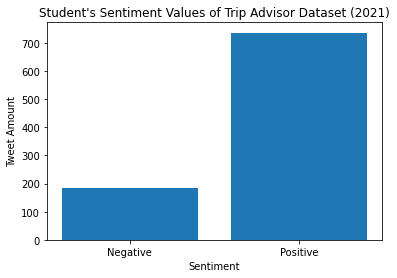

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df_vader = [analyzer.polarity_scores(text) 
            for text in df_2021.text.to_list()]

df_vader = df_2021.copy()

for idx, row in df_vader.iterrows():
    sentiment = analyzer.polarity_scores(row['text'])
    df_vader.at[idx, sentiment.keys()] = sentiment.values()
    
df_vader.to_csv('vader.csv')

df_vader.head()
plot_sentiment_analysis(df_2021, prefix='Student')

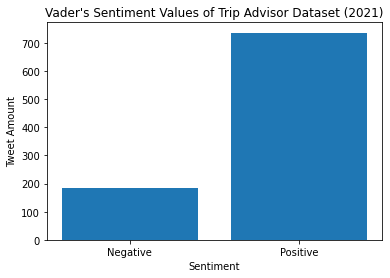

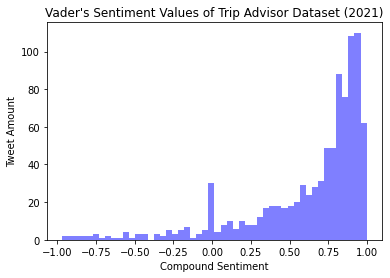

In [60]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def histogram_sentiment_analysis(df: pd.DataFrame, num_bins: int = 50, prefix: str = '') -> None:
    n, bins, patches = plt.hist(df['compound'], num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel("Compound Sentiment")
    plt.ylabel("Tweet Amount")
    plt.title(f"{prefix}'s Sentiment Values of Trip Advisor Dataset (2021)")
    plt.show()

    
plot_sentiment_analysis(df_vader, prefix='Vader')
histogram_sentiment_analysis(df_vader, prefix='Vader')

In [38]:
print('Truth Predicted Tweet')
for x, y in zip(test_x, test_y):
    y_hat = naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print(f"{y}\t{int(np.sign(y_hat) > 0)}\t{' '.join(pre.process_tweet(x))}")
        
def candlestick(df: pd.DataFrame) -> None:
    # Extracting Data for plotting
    data = list()
    for month, df_by_month in pd.groupby('travel_date'):
        row { 
            'High': df_by_month.max(),
            'Low': df_by_month.min(),
    ohlc = data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]

    # Converting date into datetime format
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)

    # Creating Subplots
    fig, ax = plt.subplots()

    candlestick_ohlc(ax, ohlc.values, width=0.6,
                     colorup='green', colordown='red', alpha=0.8)

    # Setting labels & titles
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    fig.suptitle('Daily Candlestick Chart of NIFTY50')

    # Formatting Date
    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    fig.tight_layout()

    plt.show()

Truth Predicted Tweet
1.0	0	
1.0	0	truly lateral move know queen bee upward movingonup
1.0	0	wake feel incredibly sick idk cause drank starbucks o'clock last night reaction med :)
1.0	0	new report talk burn calorie cold work hard warm feel good weather :p
1.0	0	
1.0	0	wanna loser ♥
1.0	0	
1.0	0	park get sunlight
1.0	0	uff itna miss karhy thy ap :p
0.0	1	lot people suggest still
0.0	1	u probs fun david
0.0	1	hi unfortunately unable locate original complaint pls dm product detail we'll get back
0.0	1	fun osaka super junior lovely watch comeback stage
0.0	1	pat jay
0.0	1	give work old staff come police later court look job bye bye
0.0	1	carter deserve hate deserve single corn chip deserve corn chip
0.0	1	thats life get call people havent see year always favour


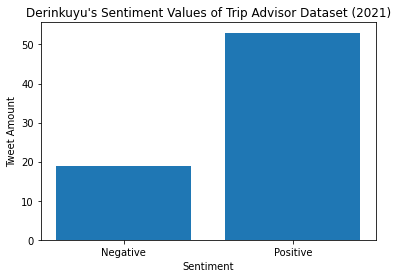

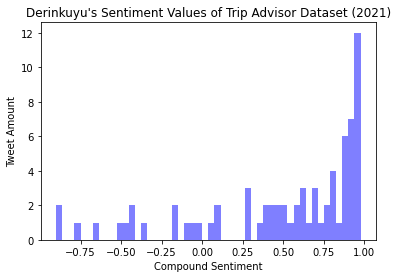

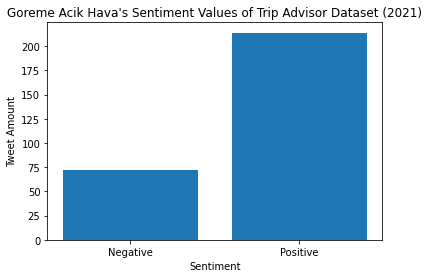

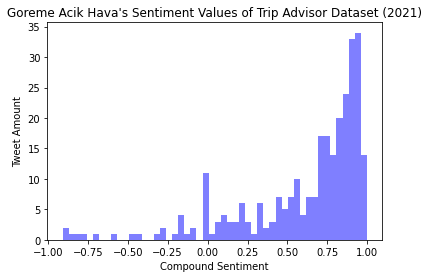

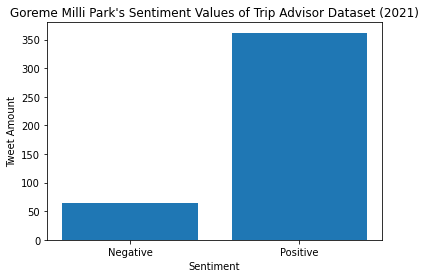

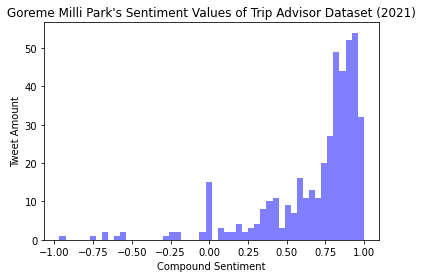

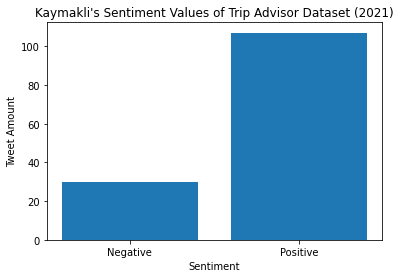

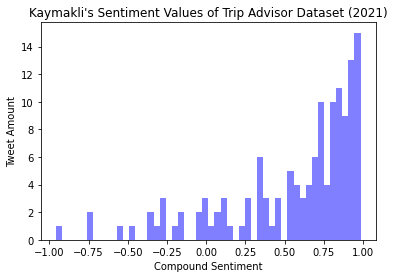

In [80]:
locations = {
    1: 'Derinkuyu',
    2: 'Goreme Acik Hava',
    3: 'Goreme Milli Park',
    4: 'Kaymakli'
}

for loc_idx, df_by_location in df_vader.groupby('location'):
    plot_sentiment_analysis(df_by_location, prefix=locations[loc_idx])
    histogram_sentiment_analysis(df_by_location, prefix=locations[loc_idx])


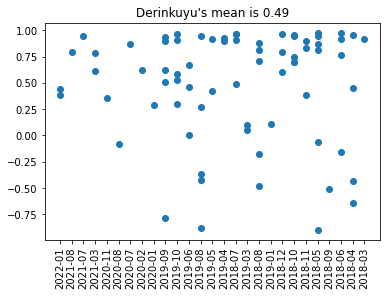

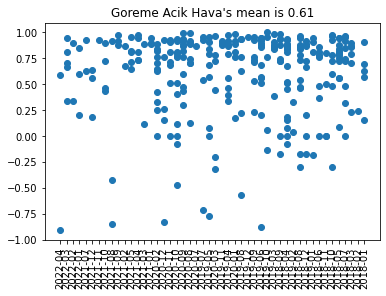

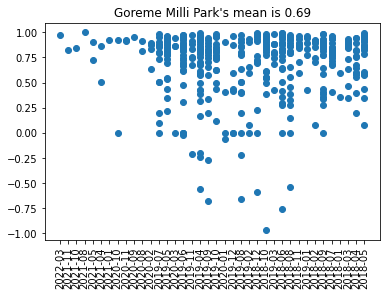

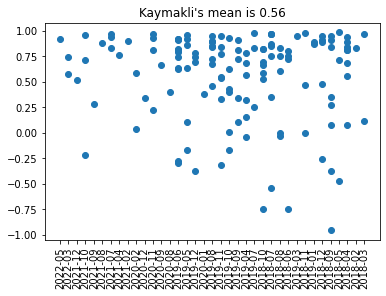

In [109]:
    
for loc_idx, df_by_location in df_vader.groupby('location'):
    data = df_by_location[['compound', 'travel_date']]
    plt.scatter(data['travel_date'], data['compound'], label='sentiment values')
    #dates,compound_means = list(), list()
    #for date, compound in data.groupby('travel_date'):
    #    dates.append(date)
    #    compound_means.append(compound.mean())
    #plt.scatter(dates, compound_means, marker='o', facecolors='none', edgecolors='orange', label='means')
    plt.xticks(rotation=90)
    plt.title(f'{locations[loc_idx]}\'s mean is {round(data["compound"].mean().item(), 2)}')
    #plt.legend()
    plt.show()